##Setup libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


##Download the csv

In [0]:
URL = 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip' #@param {type:"string"}
dir_name = 'jena_climate_2009_2016.csv.zip' #@param {type:"string"}

zip_path = tf.keras.utils.get_file(
    origin=URL,
    fname=dir_name,
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In both the following time series, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [0]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

##Exploratory data analysis

In [0]:
df = pd.read_csv(csv_path)

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations.

In [0]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


First, we can notice that there is no missing values in this dataset according to that all values in count row is 420551. Second, we can get the basic idea of how each attribute are distribute after acquiring the five number summary of all attributes. Take sh (g/kg) column for example, the min and max is about 0.5 and 18 respectively. Hence, we expect that the 50th percentile should be near to 10. However, the 50th percentile is 6, much lower than what we expected. This indicate the distribution of sh (g/kg) column is right-skewed. Third, besides the five number summary, standard deviation give us an insight into the degree that these attributes spread. Based on the range and standard deviation, even though column P (mbar) and T (degC) have close standard deviations (8.360583, 8.420257), the range sizes 100 and 60, approximately, determine the P (mbar) degree of spreading will be greater than T (degC).

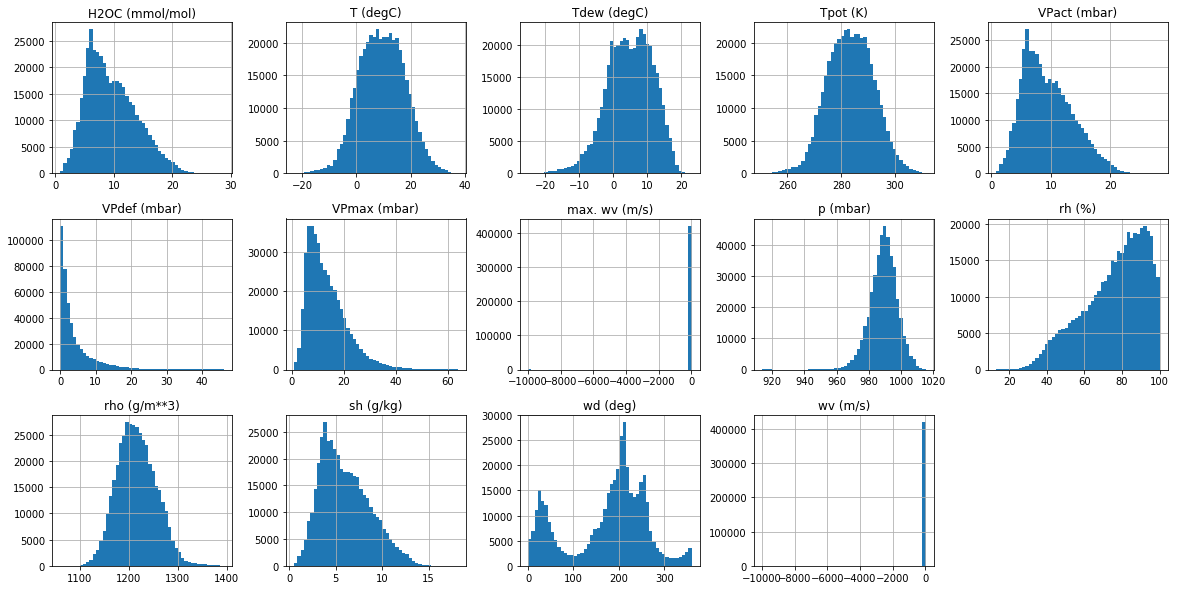

In [0]:
df.hist(figsize=(20,10),layout=(3,5), bins=50)
print('')

Above plots depicts how each attribute is distributed. Column T, p, Tpot, rho, and Tdew are pretty well bell-shaped distributed. Column wv and max.wv are virtually a bar that indicates all values in these two attributes are highly condensed. Column VPdef has a exponential distribution. Column VPmax, VPact, sh and H2OCa are right-skewed, and column rh is left-skewed. Column wd has bimodal distribution.

###Correlation Matrix

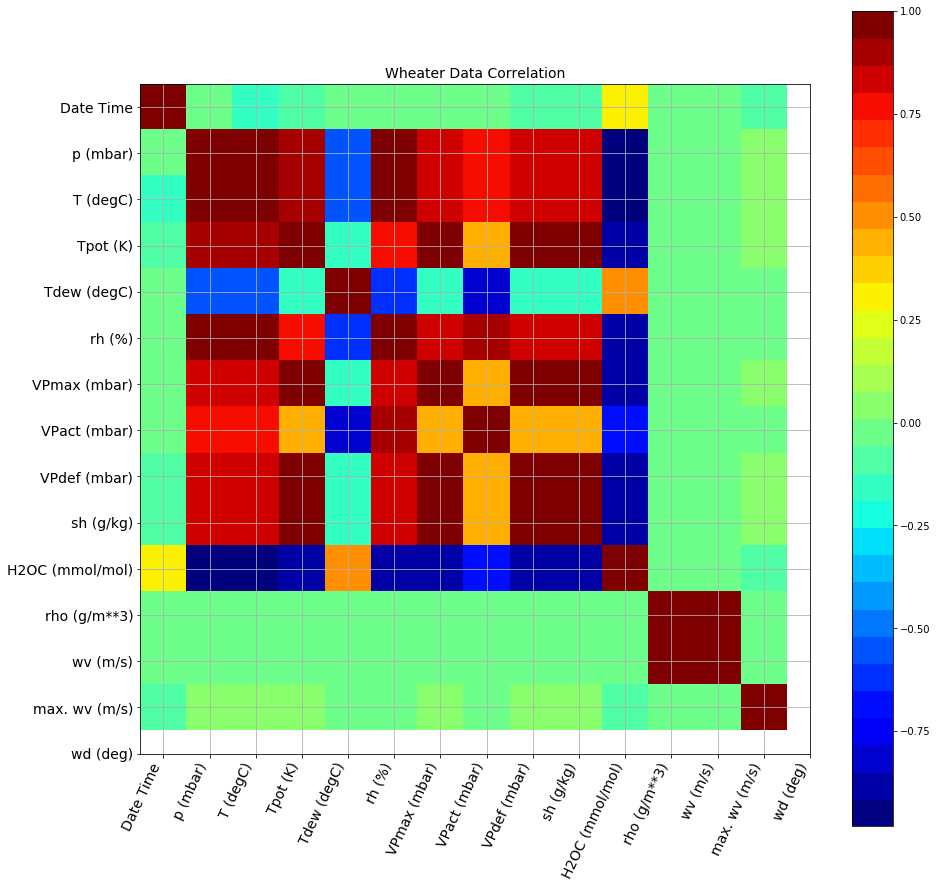

In [0]:
def correlation_matrix(df,title):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title(title,fontsize=14)
    labels=list(df)
    ax1.set_xticks([i for i in range(len(labels))])
    ax1.set_xticklabels(labels,fontsize=14,rotation=65, horizontalalignment="right")
    ax1.set_yticks([i for i in range(len(labels))])
    ax1.set_yticklabels(labels,fontsize=14)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-1.0,-0.75,-0.5,-0.25,.0,.25,.50,.75,1])
    plt.show()

correlation_matrix(df,'Wheater Data Correlation')

For dependent variable, correlation matrix plot helps to obtain how each independent variable contributes in predicting T. In result, attribute p, wv, max.wv and wd seem to have no contribution in predicting target variable. In contrary, attribute Tpot, Tdew, VPmax, VPact, VPdef, sh and H2OC have positive and strong relationship with T. Attribute rho has negative and strong relationship with the target variable and attribute rh has negative and moderate relationship with the target variable.

For independent variables, correlation matrix plot helps to spot multicollinearity issue. In the plot, independent variable tpot, VPmax, Tdew, VPact, sh, and H2OC are highly correlated (with almost 1 correlation).

##Forecast Time Series
The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density.

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [0]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


How each of these features vary across time...

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a5c8840f0>,
      dtype=object)

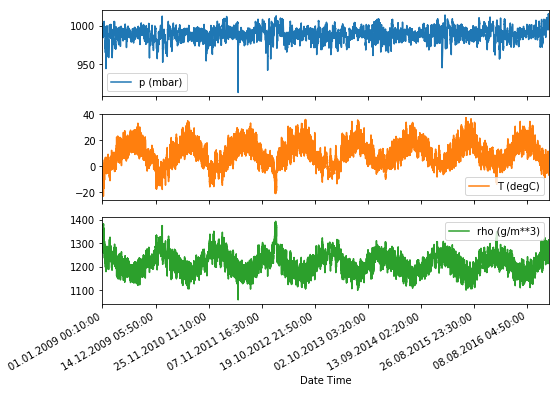

In [0]:
features.plot(subplots=True)

Normalize the dataset using the mean and standard deviation of the training data

In [0]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

The below function samples the past observation based on the step size given

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

##Single step model

In [0]:
past_history = 720  # lookback (shown data from last 5 days)
future_target = 72  # delay (targets will be 6hrs in the future)
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Single data point

In [0]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential


single_step_model = Sequential()
single_step_model.add(LSTM(32, input_shape=x_train_single.shape[-2:]))

single_step_model.add(Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')




Sample prediction

In [0]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


###Train the model

In [0]:
EPOCHS = 40

single_step_history = single_step_model.fit(train_data_single, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=200,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/40
200/200 [==============================] - 8s 41ms/step - loss: 0.3395 - val_loss: 0.2647
Epoch 2/40
200/200 [==============================] - 5s 25ms/step - loss: 0.2671 - val_loss: 0.2470
Epoch 3/40
200/200 [==============================] - 5s 25ms/step - loss: 0.2700 - val_loss: 0.2445
Epoch 4/40
200/200 [==============================] - 5s 25ms/step - loss: 0.2661 - val_loss: 0.2486
Epoch 5/40
200/200 [==============================] - 5s 25ms/step - loss: 0.2340 - val_loss: 0.2429
Epoch 6/40
200/200 [==============================] - 5s 25ms/step - loss: 0.2469 - val_loss: 0.2784
Epoch 7/40
200/200 [==============================] - 5s 25ms/step - loss: 0.2501 - val_loss: 0.2614
Epoch 8/40
200/200 [==============================] - 5s 25ms/step - loss: 0.2490 - val_loss: 0.2485
Epoch 9/40
200/200 [==============================] - 5s 25ms/step - loss: 0.2523 - val_loss: 0.2549
Epoch 10/40
200/200 [===========================

###Plot the data

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

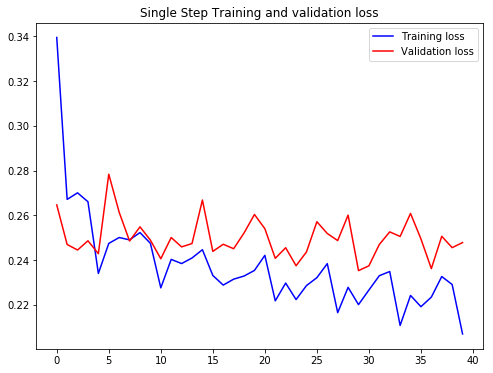

In [0]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

###Predict Single Step Future

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

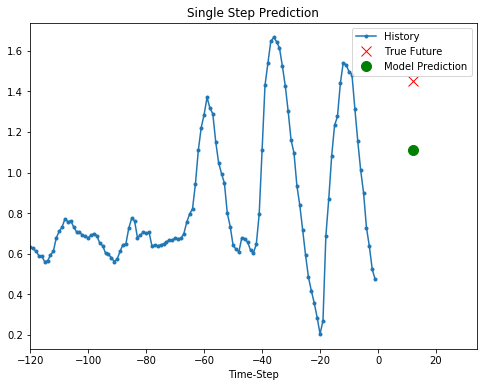

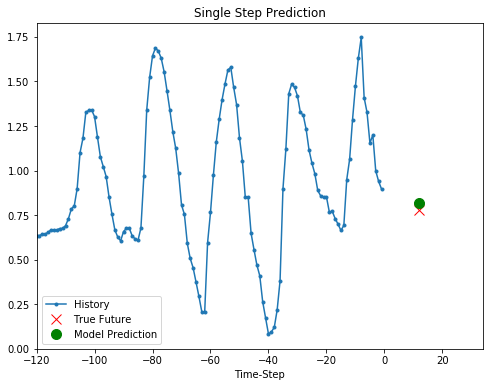

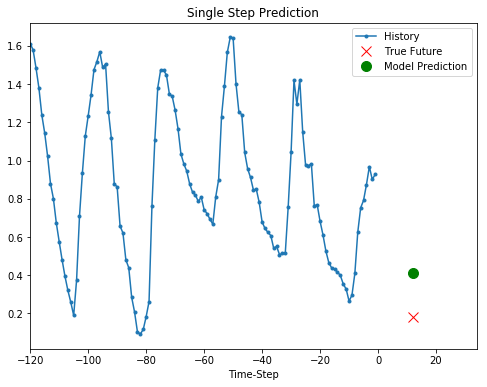

In [0]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

##Multi step Model
Multi-step models predict a sequence of the future

The model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [0]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

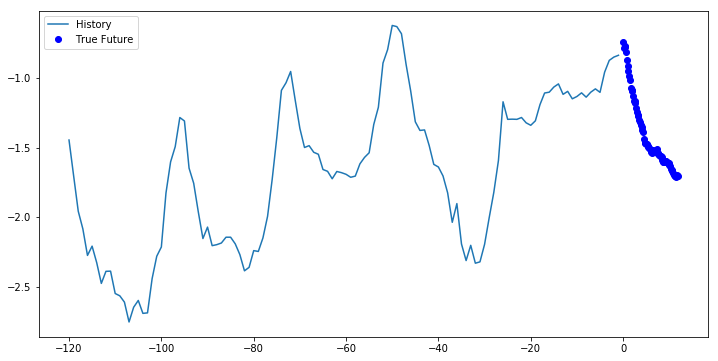

In [0]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [0]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [0]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=200,,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

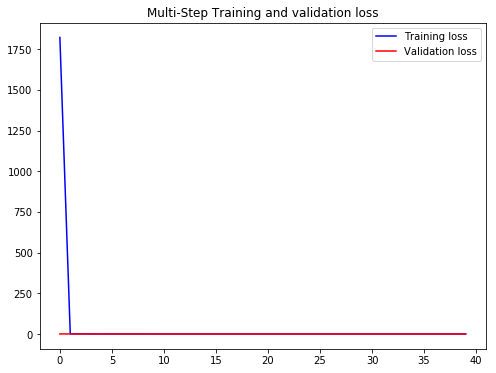

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

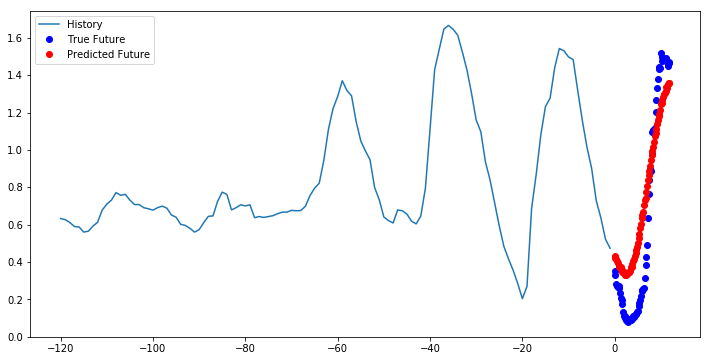

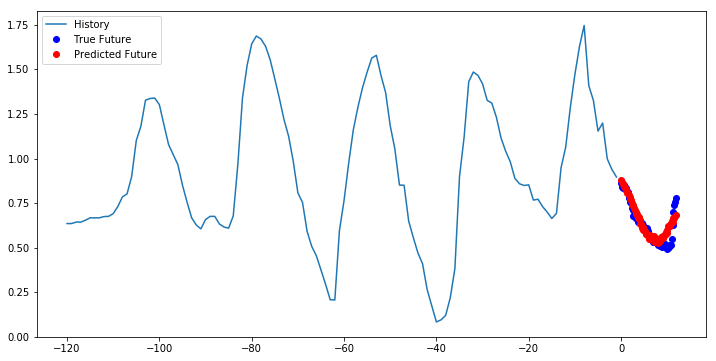

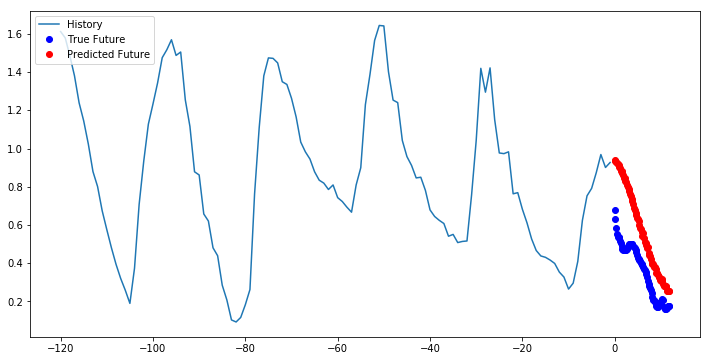

In [0]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])